<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Insights" data-toc-modified-id="Insights-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Insights</a></span></li></ul></div>

# EDA

In [14]:
# import modules
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import metrics

plt.style.use('seaborn')

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

%matplotlib inline

In [3]:
#load data
file = 'data/salary.csv'
df = pd.read_csv(file)

In [4]:
def data_exp():
    """explore dataset"""
    profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
    return profile.to_widgets()

data_exp()

build report structure: 100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


# Data Cleaning

In [5]:
# replace the missing value with the mean
df['salary'] = df.fillna(df['salary'].mean())

# detecting extreme values using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# removing outliers from the dataset
df_new = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    

# Feature Engineering

In [6]:
cat_columns = ["Field"]
df_processed = pd.get_dummies(df_new, prefix_sep="_", columns=cat_columns, drop_first=False)



In [7]:
df_processed.rename(columns={'Field_1': 'Engineering', 'Field_2': 'Finance', 'Field_3':'Human Resources', 'Field_4':'Marketing'}, inplace=True)


In [8]:
del df_processed["Human Resources"]

#df_processed.head(1)

# Model Training

In [9]:
# split data
train, test = train_test_split(df_processed, test_size=0.3, random_state=1)

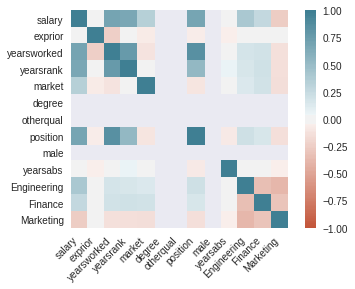

In [10]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [18]:
# run model 
salary_model = ols("salary ~ yearsworked + yearsrank + market + Engineering + Finance", data=train).fit()
print(salary_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     129.5
Date:                Fri, 20 Mar 2020   Prob (F-statistic):           1.18e-63
Time:                        21:18:22   Log-Likelihood:                -2296.1
No. Observations:                 227   AIC:                             4604.
Df Residuals:                     221   BIC:                             4625.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.044e+04   3022.314      3.455      

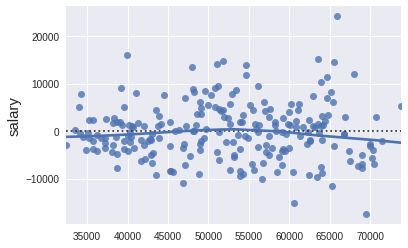

In [19]:
y_sal = train.salary

# fitted values (need a constant term for intercept)
model_fitted_y = salary_model.fittedvalues

# model residuals
model_residuals = salary_model.resid

sns.residplot(x=model_fitted_y, y= y_sal, lowess=True)

In [24]:
#train data
y_train = train.salary
X_train = train[['exprior', 'yearsworked', 'yearsrank', 'market', 'Engineering', 'Finance']]

#test data
y_test = test.salary
X_test = test[['exprior', 'yearsworked', 'yearsrank', 'market', 'Engineering', 'Finance']]

# Instantiate model
lm1 = LinearRegression()

# Fit model
lm1.fit(X_train, y_train)


# Predict
y_pred_train = lm1.predict(X_train)


# RMSE
print(np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

5807.845973711201


In [23]:
# Instantiate model
lm2 = LinearRegression()

# Fit model
lm2.fit(X_test, y_test)


# Predict
y_pred_test = lm2.predict(X_test)


# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

5366.545467641096


# Insights